# Lecture 5: Deltas and Hedging

Topics:

* Derivatives, Deltas and Hedging 
* Risk transformation
* Hedge Optmization
* Brownian Bridge
* Numerical integration

In [1]:
%pylab inline

import numpy as np
import pandas as pd
import inst 
import fmt

lecture = 5

Populating the interactive namespace from numpy and matplotlib


# Derivatives, Deltas and Hedging

Judd Gregg: Derivatives are a huge, complex issue.

## Finite difference

The derivative of a smooth function $f(t)$ can be approximated numerically by finite difference schemes:

* Forward difference: $\frac{df(x)}{dx} \approx \frac{f(x+\epsilon) - f(x)}{\epsilon} + O(\epsilon)$
* Backward difference: $\frac{df(x)}{dx} \approx \frac{f(x) - f(x-\epsilon)}{\epsilon} + O(\epsilon)$
* Central difference: $\frac{df(x)}{dx} \approx \frac{f(x+\epsilon) - f(x-\epsilon)}{2\epsilon} + O(\epsilon^2)$
* 2nd order derivative: $\frac{d^2f(x)}{dx^2} \approx \frac{f(x+\epsilon) - 2f(x) + f(x-\epsilon)}{\epsilon^2} + O(\epsilon^2)$


Central scheme has higher order of accuracy, requires two valuations of $f$.
* The accuracy of finite difference schemes can be verified via Taylor expansions.

## Generic pricing function

A pricing function can be written very generically as: $\renewcommand{bs}{\boldsymbol} v = v(\bs i, \bs m, \bs c, t)$, the inputs are:

* $\bs i$: the instrument itself, such as maturity, coupon rate etc
* $\bs m$: market environment, such as IR, CDS, FX rate etc
* $\bs c$: model parameters and assumptions, 
  * static parameters, e.g.: the tension spline parameter $\lambda$ 
  * parameters calibrated to market inputs, e.g.: implied vol
* $t$: time

The pricing function can be viewed as an interpolator.

## Greeks

The following terminologies are often used in practice
* Delta: 1st order derivative to market environments: $\bs \delta = \frac{\partial v}{\partial \bs m}$
 * Delta is a vector of size $m$
 * Deltas are in the unit of currency
* Gamma: 2nd order derivaties to market environments: $\Gamma = \frac{\partial \bs \delta}{\partial \bs m}$
 * Gamma is a $m \times m$ matrix that includes all cross gammas
* Theta: $\theta = \frac{\partial v}{\partial t}$
* Derivatives are also defined for certain common model parameters:
 * Vega: derivative to implied volatility

## How to compute Deltas

Deltas are often computed by brute force
  * bump, recalibrate, revalue
  * slow, but generic and robust
  
Advanced method of computing Delta
  * automatic algorithmic differentiation (AAD)
  * Jacobian inversion

## Dynamic hedging

The purpose of dynamic hedging is to remove the unwanted risks:

* Compute Deltas to all relevant market risk factors
* Aggregate the risk sensitivities to the portfolio level
* Put on hedges that neutralize the portfolio's sensitivities to unwanted risk factors
* The hedges are rebalanced frequently
* Dynamic hedging allows a market maker to trade and risk manage illiquid derivatives
* Risk managers impose limits on deltas to key risk factors

## PnL explained:

* Attribute daily PnL to market risk factor changes
* A critical step for a trading desk's operation in practice

At a very high level, the PnL explain is the total derivative:

$$\renewcommand{bs}{\boldsymbol}  d v = \frac{\partial v}{\partial \bs i} d \bs i + \frac{\partial v}{\partial \bs m} d \bs m + \frac{\partial v}{\partial \bs c} d \bs c + \frac{\partial v}{\partial t} dt $$

* if the two sides differ a lot, the dynamic hedging is not working
* on a normal day, the explained PnL should be more than 90%

## A Delta hedging example

Given the following liquid benchmark CDS quotes of an issuer:

In [2]:
ir_rate = 0.02
disc = inst.FlatCurve(ir_rate)

terms = np.array([.25, .5, 1., 2, 3, 5, 7, 10])
qs = np.array([80, 85, 95, 154, 222, 385, 451, 480])

cps = np.ones(len(terms))*100 # coupon
insts = [inst.CDS(m, c*1e-4, .4) for m, c in zip(terms, cps)] # instantiates CDS instruments

#compute the upfront PV of the benchmark instruments
ufr = np.array([i.pv01(disc, inst.FlatCurve(f*1e-4))*(c-f)*1e-4 for i, f, c in zip(insts, qs, cps)])

mat_tag = 'Maturity (Y)'

cds_data = pd.DataFrame({mat_tag:terms, 'Coupon(bps)':cps, 'Quoted Spread(bps)':qs, 
                         'PV (% Points)': ufr*100.}).set_index(mat_tag)
fmt.displayDF(cds_data.T, "4g")
benchmarks = dict(zip(insts, ufr))

lbdm = 10

Maturity (Y),0.25,0.5,1.0,2.0,3.0,5.0,7.0,10.0
Coupon(bps),100,100,100,100,100,100,100,100
PV (% Points),0.04965,0.0742,0.04909,-1.038,-3.42,-12.26,-19.57,-27.34
Quoted Spread(bps),80,85,95,154,222,385,451,480


How to hedge the risk of a long $10MM, 4.5Y, 500bps coupon CDS position?

We make the following assumptions:
* the interest rate is always a flat curve
  * there is a liquid 5Y zero coupon bond in the market to determine the flat interest rate (*by J)
* the CDS curve is built using a tension spline with $\lambda = 10$

## Why spreads?

The market trades in prices but market participants communicate in spreads:

| Instruments | Quotes |
| :---: | :----: |
| Bond | yield, z-spread, BCDS, OAS |
| Options | implied vol |
| CDS | quoted spread, par spread |
| ABS/MBS/CLO | discount margin |

**PV01** : the ratio of PV changes in bps over 1bps spread change

The advantages of spread over price includes:
* free of the dirty/clean price ambiguity
* comparable between different instruments
* spreads are annualized, stable over time
  * price of bonds will pull to par at maturity

## Replicating and hedging portfolio

Given: 

* $v$ is the PV of the trade or portfolio to be hedged
* $\bs b$ is a vector of benchmark instruments' **PV**s 
  * $\bs b$ is usually in unit notional, by convention
* $\bs q$ is the vector of benchmark quotes, usually in **spreads** 
  * e.g. the quoted spreads for CDS, par swaps for rates etc

The replicating portfolio $\bs h^T \bs b$ is a benchmark portfolio that has identical first order risk to $v$: 

$$\frac{\partial v}{\partial \bs q}  = \frac{\partial (\bs h^T \bs b)}{\partial \bs q} = \bs h^T  \frac{\partial \bs b}{\partial \bs q} \iff \bs h^T = \frac{\partial v}{\partial \bs q} (\frac{\partial \bs b}{\partial \bs q})^{-1} $$

Or more directly:

$$
\bs h^T = \frac{\partial v}{\partial \bs b} = \frac{\partial v}{\partial \bs q}\frac{\partial \bs q}{\partial \bs b} = \frac{\partial v}{\partial \bs q}(\frac{\partial \bs b}{\partial \bs q})^{-1}
$$

* $\frac{\partial v}{\partial \bs q}$ are the Deltas of the bespoke instrument
* $\frac{\partial \bs b}{\partial \bs q}$ are the Deltas of the benchmark instruments.

$-\bs h^T \bs b$ is the portfolio to netrualize all the first order risks, commonly referred as the hedging portfolio.

* this equation is the core of a market maker's operation
* we can trade illiquid instrument and hedge them using liquid benchmarks
* economy of scale, the hedge is only on the portfolio level

## Benchmark Jacobian

$\frac{\partial \bs b}{\partial \bs q}$ is the Jacobian of benchmark instruments over benchmark quotes


In this example, the benchmark instrument $\bs b$ includes:

* the standard CDS with 100bps coupon at benchmark tenors
* the 5Y zero coupon bond

The benchmark quotes $\bs q$ includes:

* quoted spread for all benchmark tenors
* the flat interest rate

## Diagonality

The benchmark Jacobian is diagonal if the dependency btw $\bs b$ and $\bs q$ has one-to-one correspondence (*by J)
  * Jacobian $\frac{\partial v}{\partial \bs q}$ requires other elements of $\bs q$ remain constant when perturbing one of them
  * other benchmark PVs remain unchanged because their $\bs q$ are hold constant
  
The $\bs b$ and $\bs q$ are not always one-to-one
  * eg, option price depends on both IR and implied vol
  * the benchmark quote is not diagonal in this case
    
The benchmark Jacobian is diagonal in our example
  * the diagonal elements of $\frac{\partial \bs b}{\partial \bs q}$ are the PV01s

When computing benchmark Jacobian numerically, we **must** re-bootstrap all dependent curves for any perturbations:
  * e.g., the CDS curve needs to be re-bootstrapped to reprice all benchmark instruments, even if we perturb IR
  * survival probability may change, but PVs are kept the same for unperturbed tenors

In [3]:
 def calcDelta(bmks, ir, lbd, trades, pert=1e-4, fpert=inst.pert_bmk) : 
    mkt, pmkt, pkeys, cds = inst.pert_bmk(bmks, disc, lbd=lbd, its=3, pert=pert)
    deltas, pv0 = inst.pv_deltas(mkt, pmkt, trades)
    
    return deltas/pert, pkeys, cds, pv0

zcb = inst.ZeroCouponBond(maturity = 5.)
bespoke = inst.CDS(maturity=4.5, coupon=0.05, recovery=0.4)
bmks = [zcb] + insts
notional = 10e6
hi_names = ['5Y ZCB'] + ['CDS @%gY' % t for t in terms] # benchmark instruments

deltas, pert_names, cds, _ = calcDelta(benchmarks, disc, lbdm, bmks + [bespoke])
pv01m = deltas[:-1, :]
pv01 = np.diag(pv01m)
db = deltas[-1, :] # delta of the bespoke, dv/dq

fmt.displayDF(pd.DataFrame(pv01, index=hi_names, columns=['PV01']).T, "2f")

,5Y ZCB,CDS @0.25Y,CDS @0.5Y,CDS @1Y,CDS @2Y,CDS @3Y,CDS @5Y,CDS @7Y,CDS @10Y
PV01,4.53,0.25,0.49,0.98,1.91,2.78,4.23,5.32,6.45


## Hedging portfolio example

Given the $\frac{\partial \bs b}{\partial \bs q}$ is diagonal, the hedge notional is simply the bespoke instrument's risks divided by benchmark instruments' PV01:

In [4]:
hedge_items = ['PV01 $= \\frac{\partial b}{\partial q}$', 
               '$\delta = 10^{-4} \\frac{\partial v}{\partial q}$', 'Hedge Not (\$MM)']

df_h_bmk = pd.DataFrame(np.array([pv01, db*notional*1e-4, -db/pv01*notional*1e-6]).T, 
                        index=hi_names, columns=hedge_items).T
fmt.displayDF(df_h_bmk, "2f")

,5Y ZCB,CDS @0.25Y,CDS @0.5Y,CDS @1Y,CDS @2Y,CDS @3Y,CDS @5Y,CDS @7Y,CDS @10Y
PV01 $= \frac{\partial b}{\partial q}$,4.53,0.25,0.49,0.98,1.91,2.78,4.23,5.32,6.45
$\delta = 10^{-4} \frac{\partial v}{\partial q}$,390.43,3.38,9.88,45.11,69.88,871.55,"3,744.18",-202.84,7.68
Hedge Not (\$MM),-0.86,-0.14,-0.20,-0.46,-0.37,-3.14,-8.85,0.38,-0.01


* note that the deltas are usually communicated in PV changes for 1bps change in spread, thus the $10^{-4}$ factor.

## Tension and hedge notional

The tension parameter has a noticeable effects on PV and hedge notionals.

* all numbers below are in million USD (hedge notional)
* the leaks (risk exposure) to longer maturities reduce with larger $\lambda$ 

In [5]:
def hedgeRatio(lbdm) :
    deltas, _, _, pv0 = calcDelta(benchmarks, disc, lbdm, bmks + [bespoke])
    pv01 = np.diag(deltas[:-1, :])
    db = deltas[-1, :]
    return np.concatenate((pv0[-1:], -db/pv01))

lbds = [0, 2, 10, 50, 5000]
hn = [hedgeRatio(l)*notional for l in lbds]

lkeys = ["$\lambda=%d$" % l for l in lbds]
df_hn = pd.DataFrame(np.array(hn)*1e-6, columns=np.concatenate((['Bespoke PV'], hi_names)), index=lkeys)

fmt.displayDF(df_hn, "3f")

,Bespoke PV,5Y ZCB,CDS @0.25Y,CDS @0.5Y,CDS @1Y,CDS @2Y,CDS @3Y,CDS @5Y,CDS @7Y,CDS @10Y
$\lambda=0$,0.567,-0.840,-0.344,0.271,-1.095,1.011,-4.248,-9.625,1.441,-0.215
$\lambda=2$,0.553,-0.846,-0.146,-0.140,-0.578,0.099,-3.507,-9.329,0.904,-0.077
$\lambda=10$,0.541,-0.863,-0.136,-0.200,-0.461,-0.366,-3.136,-8.853,0.381,-0.012
$\lambda=50$,0.534,-0.875,-0.140,-0.211,-0.440,-0.544,-3.014,-8.541,0.100,-0.001
$\lambda=5000$,0.532,-0.880,-0.141,-0.214,-0.436,-0.600,-2.979,-8.424,0.001,0.000


## Valuation and hedging ambiguity?

The PV and hedge notionals depend on $\lambda$
  * two parties may not agree on the PVs and risks of the trades, because of model differences
    * the quoted spreads are a few bps apart due to different $\lambda$
    * this contributes to a wider bid/offer for off-the-runs
    * a common headache in operation, e.g. collateral posting
  * the ambiguity is a reflection of incomplete market, not an arbitrage opportunity
  
Dynamic hedging in practice:
  * can't possibly remove all risks, eg. jump-to-default risk
  * the cost of hedging over time won't add up to the PV of the instruments

# Risk Transformation

Warren Buffet: Risk comes from not knowing what you're doing.

## CDS big bang

The big bang of CDS standardisation occured in 2010:

|  Era   | Liquid Instruments | Quoting Convention | At Trade Inception | Counterparty |
| :---: | :----: | :----: | :-----: |
| before |  par spread CDS | par spreads | $PV=0$, <br> no cash exchange | OTC |
| after | standardised CDS with 100/500 cpn | quoted spreads, upfront | $PV \ne 0$, <br> cash exchange | central clearing |

At its core, it is simply a change in the liquid benchmark instruments.
* the quoting convention change is a side product
* ISDA publishes a one-day-lagged IR curve for the conversion of quoted spreads to PV, to ensure that the standardised CDS PV is solely determined by the corresponding quoted spread. 

## Real world hedging problem

However, your bank's IT system hasn't been updated in time (it never does). 

In your bank:

* end of day valuation still builds CDS curves from the par CDS spread
* traders have to continue marking the par spreads, even though they all trade standardised CDS using quoted spreads
* risks (Deltas) are all computed with regard to par CDS

From your bank's system point of view (contrary to the market): 

* the par CDS is still the benchmark instruments
* the standardised CDS are the bespoke instruments you now have to hedge your positions with

How do you continue to trade and hedge your book?

## Par spread $\leftrightarrow$ quoted spread

the equivalent par CDS spreads ($\bs p$) and quoted spreads ($\bs q$) are shown below.
* the conversion btw par spreads $\bs p$ and quoted spreads $\bs q$ is easy
  * $\bs q \rightarrow$ CDS curve $\rightarrow \bs p \rightarrow$ CDS Curve
  * the last step is done by the end of day official IT system
* CDS curves built from converted $\bs q$ and $\bs p$ are identical


In [6]:
pars = np.array([i.par(disc, inst.zero2disc(cds)) for i in insts])
cds_data['Par Coupon (bps)'] = pars*1e4
fmt.displayDF(cds_data.T, "3g")
bmk_par = {inst.CDS(i.maturity, s, .4) : 0 for i, s in zip(insts, pars)}

Maturity (Y),0.25,0.5,1.0,2.0,3.0,5.0,7.0,10.0
Coupon(bps),100,100,100,100,100,100,100,100
PV (% Points),0.0497,0.0742,0.0491,-1.04,-3.42,-12.3,-19.6,-27.3
Quoted Spread(bps),80,85,95,154,222,385,451,480
Par Coupon (bps),80,85,95,154,223,390,468,524


where do the par spread and quoted spread diverge?

## What people often do

Compute the hedge ratio as:

* computes bespoke trade's deltas to par spreads: $\frac{\partial v}{\partial p_i}$
* compute the PV01 of standardised CDS to par spreads, i.e, $\frac{\partial b_i}{\partial p_i}$
* compute the hedge notional as the ratio of the bespoke delta and PV01s, both to par spread

The following are the results:

In [7]:
deltas_p, pert_names, _, _ = calcDelta(bmk_par, disc, lbdm, bmks + [bespoke])
pv01m_p = deltas_p[:-1, :]
pv01_p = np.diag(pv01m_p)
db_p = deltas_p[-1, :]

hedge_items_p = [l.replace(' q', ' p') for l in hedge_items]
hn_p = pd.DataFrame(np.array([pv01_p, db_p*notional*1e-4, -db_p/pv01_p*notional*1e-6]).T, 
                        index=hi_names, columns=hedge_items_p).T

fmt.displayDF(hn_p, "2f")

,5Y ZCB,CDS @0.25Y,CDS @0.5Y,CDS @1Y,CDS @2Y,CDS @3Y,CDS @5Y,CDS @7Y,CDS @10Y
PV01 $= \frac{\partial b}{\partial p}$,4.53,0.25,0.49,0.98,1.90,2.74,4.00,4.97,5.77
$\delta = 10^{-4} \frac{\partial v}{\partial p}$,124.94,1.17,3.38,16.16,-2.26,710.73,"3,556.26",-181.90,6.28
Hedge Not (\$MM),-0.28,-0.05,-0.07,-0.17,0.01,-2.59,-8.89,0.37,-0.01


## is incorrect

There are serious errors in the resulting hedging portfolio

* in particular the IR hedge amount is very wrong
* leading to mishedges, confusions and headaches 

In [8]:
ih = -db_p.dot(np.linalg.inv(pv01m_p))*notional
hns = pd.DataFrame([-db_p/pv01_p*notional, -db/pv01*notional, ih], columns=hi_names, 
                    index=['Par CDS $\\delta$/PV01', 'Exact H/N', 'Inverted H/N'])
fmt.displayDF(hns[:-1]*1e-6, "4f")

,5Y ZCB,CDS @0.25Y,CDS @0.5Y,CDS @1Y,CDS @2Y,CDS @3Y,CDS @5Y,CDS @7Y,CDS @10Y
Par CDS $\delta$/PV01,-0.2761,-0.0472,-0.0685,-0.1651,0.0119,-2.5896,-8.8937,0.3662,-0.0109
Exact H/N,-0.8628,-0.1362,-0.2001,-0.4611,-0.3656,-3.1362,-8.8529,0.3814,-0.0119


The root cause is that the $\frac{\partial \bs b}{\partial \bs p}$ is not a diagonal matrix
* $\bs p$ is quotes for par CDS instruments, it is not one to one with $\bs b$, the standardised CDS
* this incorrect procedure ignores all off diagonal elements in $\frac{\partial \bs b}{\partial \bs p}$ 

The following is the full Jacobian matrix of the standardised CDS with 100bps coupon to par spread perturbations $\frac{\partial \bs b}{\partial \bs p}$:

In [9]:
fmt.displayDF(pd.DataFrame(pv01m_p, index=hi_names, columns=pert_names), "4f")

,IR,CDS @0.25Y,CDS @0.50Y,CDS @1Y,CDS @2Y,CDS @3Y,CDS @5Y,CDS @7Y,CDS @10Y
5Y ZCB,4.5253,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
CDS @0.25Y,0.0001,0.2481,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
CDS @0.5Y,0.0003,0.0002,0.4940,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
CDS @1Y,0.0003,0.0000,0.0002,0.9788,-0.0000,0.0000,-0.0000,0.0000,-0.0000
CDS @2Y,-0.0115,-0.0005,-0.0015,-0.0067,1.9003,0.0004,-0.0000,0.0000,-0.0000
CDS @3Y,-0.0543,-0.0011,-0.0032,-0.0140,-0.0377,2.7446,0.0005,-0.0000,0.0000
CDS @5Y,-0.3067,-0.0022,-0.0065,-0.0287,-0.0708,-0.1771,3.9986,0.0094,-0.0003
CDS @7Y,-0.6523,-0.0023,-0.0068,-0.0303,-0.0750,-0.1833,-0.4337,4.9664,0.0077
CDS @10Y,-1.2097,-0.0020,-0.0058,-0.0257,-0.0635,-0.1556,-0.3520,-0.7054,5.7724


For comparison, we also the full Jacobian matrix of stardardised CDS to quoted spreads $\frac{\partial \bs b}{\partial \bs q}$, showing that it is indeed diagonal, so we can take the PV01 short cut.

In [10]:
fmt.displayDF(pd.DataFrame(pv01m, index=hi_names, columns=pert_names), '4f')

,IR,CDS @0.25Y,CDS @0.50Y,CDS @1Y,CDS @2Y,CDS @3Y,CDS @5Y,CDS @7Y,CDS @10Y
5Y ZCB,4.5253,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
CDS @0.25Y,0.0000,0.2479,0.0000,0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000
CDS @0.5Y,-0.0000,-0.0000,0.4937,-0.0000,-0.0000,-0.0000,-0.0000,0.0000,-0.0000
CDS @1Y,-0.0000,-0.0000,0.0000,0.9785,-0.0000,-0.0000,-0.0000,0.0000,-0.0000
CDS @2Y,-0.0000,-0.0000,-0.0000,0.0000,1.9111,-0.0000,-0.0000,-0.0000,0.0000
CDS @3Y,-0.0000,0.0000,0.0000,0.0000,0.0000,2.7790,-0.0000,-0.0000,-0.0000
CDS @5Y,0.0000,-0.0000,-0.0000,-0.0000,0.0000,-0.0000,4.2293,0.0000,0.0000
CDS @7Y,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,5.3189,0.0000
CDS @10Y,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,6.4548


## Full inversion

The following hedge ratio and notional are obtained by inverting the full Jacobian matrix of standardised CDS to par spreads: 

$$\bs h^T = -  \frac{\partial v}{\partial \bs p} (\frac{\partial \bs b}{\partial \bs p})^{-1} $$

We did get the correct hedging portfolio.

In [11]:
fmt.displayDF(hns*1e-6, "4f")

,5Y ZCB,CDS @0.25Y,CDS @0.5Y,CDS @1Y,CDS @2Y,CDS @3Y,CDS @5Y,CDS @7Y,CDS @10Y
Par CDS $\delta$/PV01,-0.2761,-0.0472,-0.0685,-0.1651,0.0119,-2.5896,-8.8937,0.3662,-0.0109
Exact H/N,-0.8628,-0.1362,-0.2001,-0.4611,-0.3656,-3.1362,-8.8529,0.3814,-0.0119
Inverted H/N,-0.8627,-0.1362,-0.2001,-0.4610,-0.3656,-3.1361,-8.8530,0.3814,-0.0119


## Delta transformation

Jacobian can transform Deltas to different market quotes:

$$ \frac{\partial v}{\partial{\bs q}} = \frac{\partial v}{\partial \bs p} \frac{\partial \bs p}{\partial \bs b} \frac{\partial \bs b}{\partial \bs q} = \frac{\partial v}{\partial \bs p} \left(\frac{\partial \bs b}{\partial \bs p}\right)^{-1} \frac{\partial \bs b}{\partial \bs q} $$

* simply a change of variables in multi-variate calculus
* the right hand side can be computed without upgrading the system
  * the first factor in the RHS is the only time-consuming part

## Be all inclusive

It is important to include all risk factors in the Jacobian matrix

 * a common mistake is to leave out the IR from the Jacobian
 * missing any risk factor in the Jacobian will lead to slow PnL bleeding that is very difficult to detect
 * rigorous PnL explain process can help identify such problems

## Deltas to internal state variables


The Jacobian matrix can also be used to speed up the delta calculation.

* So far, we compute the deltas to market observables, such as quoted spreads or par spreads. 
* But this is not the only choice, we could compute deltas to model's internal state variables instead.

Let consider computing all deltas of CDS to the cumulative hazard $g(t)$, which is a the natural state variable of the curve interpolation:

$$ \frac{\partial v}{\partial{\bs q}} = \frac{\partial v}{\partial \bs g} \frac{\partial \bs g}{\partial \bs b} \frac{\partial \bs b}{\partial \bs q} = \frac{\partial v}{\partial \bs g} \left(\frac{\partial \bs b}{\partial \bs g}\right)^{-1}\frac{\partial \bs b}{\partial \bs q} $$

* $\bs g$ is the value of $g(t)$ at the benchmark tenors
* the $\frac{\partial \bs q}{\partial \bs b}$ is a diagonal matrix of 1/PV01

## Fast delta calculation

$$ \frac{\partial v}{\partial{\bs q}}  = \frac{\partial v}{\partial \bs g} \left(\frac{\partial \bs b}{\partial \bs g}\right)^{-1}\frac{\partial \bs b}{\partial \bs q} $$

* the right hand side is much easier to compute than $\frac{\partial v}{\partial \bs q}$
* RHS no longer requires re-bootstraping the curves

The same Detlas are computed at a much lower cost that the brute-force bump and recalc.

In [12]:
def calcCurveDelta(ir, cds, lbd, trades, pert=1e-4) :
    mkt, mktp, pkeys, _ = inst.pert_curve(ir, cds, pert) 
    deltas, _ = inst.pv_deltas(mkt, mktp, trades)

    return deltas/pert, pkeys, cds

deltas_c, _, _ = calcCurveDelta(disc, cds, lbdm, bmks + [bespoke])
pv01m_c = deltas_c[:-1, :]
pv01_c = np.diag(pv01m_c)
db_c = deltas_c[-1, :]
id_c = db_c.dot(np.linalg.inv(pv01m_c)).dot(pv01m)

hn_c = pd.DataFrame(np.array([db_c, db, id_c]).T*1e-4*notional, index=hi_names,
                      columns=['$\delta$ to $g(t)$', '$\delta$ to quoted spreads', 
                               'Inverted $\delta$ to q.s.']).T

fmt.displayDF(hn_c, "2f")

,5Y ZCB,CDS @0.25Y,CDS @0.5Y,CDS @1Y,CDS @2Y,CDS @3Y,CDS @5Y,CDS @7Y,CDS @10Y
$\delta$ to $g(t)$,23.29,14.79,21.39,46.59,43.09,185.00,353.27,-11.77,0.25
$\delta$ to quoted spreads,390.43,3.38,9.88,45.11,69.88,871.55,"3,744.18",-202.84,7.68
Inverted $\delta$ to q.s.,390.43,3.38,9.88,45.11,69.88,871.68,"3,744.57",-203.01,7.69


# Hedge Optimization

Edmund North: there's a difference between a gamble and a calculated risk.

## Cost of hedging

Hedging are costly in practice

* bid/ask, capital, financing, rebalancing  etc

But not hedging is usually more costly

We need to minimize the cost of hedging
 * desks/traders often choose not to zero out all unwanted risks
 * there are only a limited number of liquid and cost effective hedging instruments

How to get the best results using a limited number of hedging instruments?

Define what is best first.

## Hedge optimization

We can formulate the problem as an optimization problem:

* a set of benchmark instruments $\bs b$ with quotes $\bs q$
* limited set of hedging instruments $\bs u$, whose deltas to $\bs q$ is the Jacobian $J = \frac{\partial \bs u}{\partial \bs q}$ 
 * the dimension of $\bs u$ is smaller than $\bs q$, $J$ is rectangular
* the portfolio PV is $v$ and its deltas are: $\bs d = (\frac{\partial v}{\partial \bs q})^T$
* we use $\bs h$ to represent the best replicating portfolio, it has the same dimension as $\bs u$
  * the hedging portfolio is of course $-\bs h$

## Partial hedge

Partial hedge is to take the subset of the full hedging portfolio, keeping notionals unchanged.

* simple, but it is a starting point
* we can use it as a baseline to evaluate other hedging stategies


Can we apply PCA analysis?

* Yes, just zero out the PVs for the first few PCs of the covariance of changes.
* People actually do this in practice

## Minimize the residual risk

The residual risk is the remaining risk after including the hedges, we can find a replicating portfolio that minimizes its L-2 norm:

$$\min_{\bs h} \Vert J^T \bs {h - d} \Vert_2$$

* a standard least square problem, the solution is:

$$ \bs h = (JJ^T)^{-1}J\bs d $$

* this approach is simple and useful in practice

Ridge regression is an easy improvement, by adding a penalty of $\lambda \Vert W \bs h \Vert_2^2$:

$$ \bs h = (JJ^T + \lambda W^T W)^{-1}J\bs d $$

## Minimize the variance

Given the covariance matrix $V$ of the risk factors $\bs q$'s *daily changes*, the variance of the hedged portfolio is:

$$\text{var} = (J^T \bs {h - d})^T V (J^T \bs {h - d})$$

The optimal replicating portfolio that minimizes the var is:

$$\small \begin{array}
\\ \frac{\partial \text{var}}{\partial \bs h} &= 2(J^T \bs {h - d})^T V \frac{\partial(J^T \bs {h - d})}{\partial \bs h} = 2(J^T \bs {h - d})^T V J^T = \bs 0 \\
\bs h^T JVJ^T &= \bs d^T V J^T \iff
JVJ^T \bs h = J V \bs d \\
\bs h &= (JVJ^T)^{-1} J V \bs d
\end{array}$$

* this approach takes into account the covariance of risk factors.

The Ridge version is:

$$\bs h = (JVJ^T + \lambda W^T W)^{-1} J V \bs d $$

## Numerical example

We use the previous example to illustrate the effects of different hedges. 

* Suppose only the ZCB and 5Y CDS are cost effective to trade
  * not an uncommon situation in the credit market
* Our bank's system only computes risks to par CDS spreads, but the hedging instruments are the standardised CDS
* The bespoke trade is long $10MM, 4.5Y and 500bps

The Jacobian $J = \frac{\partial \bs u}{\partial \bs p}$ is:

In [13]:
hi = np.array([0, 6])
hnm = ['ZCB', '5Y CDS']
jac = np.array(pv01m_p)[hi, :].T
lsqm = np.linalg.inv(jac.T.dot(jac)).dot(jac.T)
fmt.displayDF(pd.DataFrame(jac.T, index = hnm, columns=pert_names), "4g")

,IR,CDS @0.25Y,CDS @0.50Y,CDS @1Y,CDS @2Y,CDS @3Y,CDS @5Y,CDS @7Y,CDS @10Y
ZCB,4.525,0,0,0,0,0,0,0,0
5Y CDS,-0.3067,-0.002196,-0.006453,-0.02874,-0.07083,-0.1771,3.999,0.009446,-0.0003262


## A stylized market

Correlation of daily rates changes:

In [14]:
n = len(hi_names)

corr = np.fromfunction(lambda i, j : .98**(abs(i-j)), (n, n))
corr[0, 1:] = corr[1:, 0] = 0
sig = np.eye(n)*15e-4
sig[0, 0] = 5e-4
cov = sig.dot(corr).dot(sig.T)
fmt.displayDF(pd.DataFrame(corr, index=hi_names, columns=hi_names), "3g")

varm = np.linalg.inv(jac.T.dot(cov).dot(jac)).dot(jac.T).dot(cov)
opt_var = varm.dot(db_p)

,5Y ZCB,CDS @0.25Y,CDS @0.5Y,CDS @1Y,CDS @2Y,CDS @3Y,CDS @5Y,CDS @7Y,CDS @10Y
5Y ZCB,1,0,0,0,0,0,0,0,0
CDS @0.25Y,0,1,0.98,0.96,0.941,0.922,0.904,0.886,0.868
CDS @0.5Y,0,0.98,1,0.98,0.96,0.941,0.922,0.904,0.886
CDS @1Y,0,0.96,0.98,1,0.98,0.96,0.941,0.922,0.904
CDS @2Y,0,0.941,0.96,0.98,1,0.98,0.96,0.941,0.922
CDS @3Y,0,0.922,0.941,0.96,0.98,1,0.98,0.96,0.941
CDS @5Y,0,0.904,0.922,0.941,0.96,0.98,1,0.98,0.96
CDS @7Y,0,0.886,0.904,0.922,0.941,0.96,0.98,1,0.98
CDS @10Y,0,0.868,0.886,0.904,0.922,0.941,0.96,0.98,1


Std dev of daily rates changes: 
* interest rate: 5bps 
* CDS spreads for all tenors: 15bps

## Optimal hedges

* The optimal hedging portfolios (in \$MM) using different methods for the bespoke trade:

In [15]:
opt_l2 = lsqm.dot(db_p).T
opt_ph = (db/pv01)[hi]
opt_pfs = [np.zeros(len(opt_l2)), opt_ph, opt_l2, opt_var]

l2 = np.array([np.linalg.norm(jac.dot(np.array(p)) - db_p, 2) for p in opt_pfs])*1e-4
vv = np.array([(jac.dot(np.array(p)) - db_p).T.dot(cov).dot((jac.dot(np.array(p)) - db_p)) 
               for p in opt_pfs])

df_opt = pd.DataFrame(np.array(opt_pfs).T, index=hnm, 
                      columns=['Unhedged', 'Partial hedge', 'Min residual risk', 'Min var']).T

df_opt['L2 norm of residual risk'] = l2
df_opt['Std dev of daily PnL'] = np.sqrt(vv)

fmt.displayDF(-df_opt.ix[:, :-2].T*notional*1e-6, "3f")

,Unhedged,Partial hedge,Min residual risk,Min var
ZCB,-0.000,-0.863,-0.872,-1.020
5Y CDS,-0.000,-8.853,-8.793,-10.974


* The performances of these portfolios matches our expectations

In [20]:
fmt.displayDF(df_opt.ix[:, -2:].T*notional, "5g")

,Unhedged,Partial hedge,Min residual risk,Min var
L2 norm of residual risk,"3,633.3",891.42,891.07,"1,247.5"
Std dev of daily PnL,"61,511","12,292","12,615","3,179.6"


* The variance minimization is an effective hedging strategy.

## Theta

In practice, we usually don't actively hedge Theta, instead we monitor it

* Source of Theta includes reduction in maturity and accrual of coupon 
* The passing of time is not volatile, it is not considered a risk factor
* Different hedges can lead to different theta profile
* It is neither feasible nor necessary to maintain a flat theta
 
Theta and convexity are often the trade off.
* Positive theta usually means negative convexity, and vice versa

# Brownian Bridge

## Interpolate the Brownian motion

Sometimes, we want to interpolate stochastically using Brownian motion:

* Fill in missing historical data
* Pricing model needs finer steps than what the simulation model produces
* the exact stochastic path is costly to compute, we want to approximate the true path using larger sampling steps

Suppose $\bs w(t)$ is a n-dimensional brownian motion, and $\bs v_T$ is its (known) terminal value, then:

$$ \bs w_b(t) = \bs w(t) - \frac{t}{T} (\bs w(T) - \bs v_T)$$ 

is the Brownian Bridge. Note that $\bs w(t)$ can be correlated.

## Examples of Brownian Bridge

A one dimensional Brownian Bridge with $w(1) = 10$:

C:\Users\Jamie\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel\__main__.py:2: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


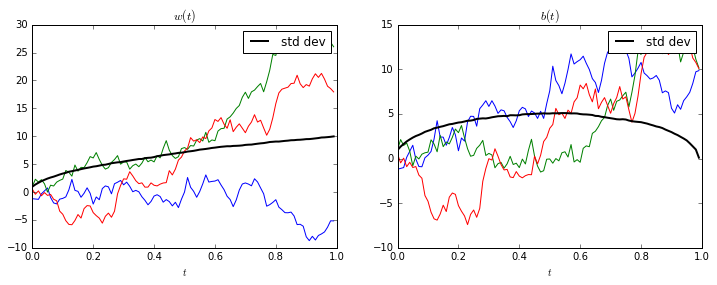

In [17]:
nt = 100.
w = np.cumsum(np.random.normal(size=[1000, nt]), 1)
dt = arange(nt)/nt

figure(figsize=[12, 4])
subplot(1, 2, 1)
plot(dt, w[:3, :].T, label="_nolegend_")
plot(dt, np.std(w, 0), 'k', linewidth=2)
legend(["std dev"])
title("$w(t)$")
xlabel("$t$")

ve = 10
subplot(1, 2, 2)
b = np.array([p - (p[-1] - ve)*dt for p in w])
plot(dt, b[:3, :].T, label="_nolegend_")
plot(dt, np.std(b, 0), 'k', linewidth=2)
legend(["std dev"])
title("$b(t)$")
xlabel("$t$");

# Numerical Integration

## Quadrature rules

To compute the definite integral of a one dimensional function:

$$ \int_a^b f(x) dx $$

* Rectangle rule: $ \int_a^b f(x) dx \approx (b-a)f(b) $
* Trapezoidal rule:  $ \int_a^b f(x) dx \approx (b-a)\frac{f(a) + f(b)}{2} $
* Simpson's rule: $\int_a^b f(x) dx \approx \frac{b-a}{6}[f(a) + 4 f(\frac{a+b}{2}) + f(b)] $

In practice, there is almost never a need to go beyond the Simpson's rule.

* We sometime run into (nearly) discountinuous $f(x)$, where the simple Trapezoidal rule works very well.
* Adaptive method can be used to achieve a desired level of acccuracy

## Accuracy of numerical integration

If the interval $[a, b]$ is divided into $N$ equal steps, then the numerical errors of the $\int_a^b f(x) dx$ for smooth function $f(x)$ are:

| Rectangle | Trapezoidal | Simpson |
| :-----: | :------: | :------: |
| $O(\frac{1}{N})$ | $O(\frac{1}{N^2})$ | $O(\frac{1}{N^4})$ |

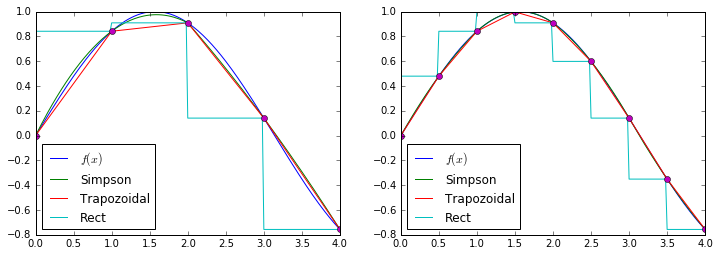

In [18]:
import lin

def plotIntegral(f, x, xs, lines) :
    plot(xs, f(xs))
    
    for k, l in lines.items() :
        l.build(x, f(x))
        plot(xs, l(xs))
        
    legend(['$f(x)$'] + lines.keys(), loc='best')

intRules = {"Rect":lin.PiecewiseFlat(), "Trapozoidal":lin.PiecewiseLinear(), "Simpson":lin.Quadratic()}

f = np.sin
x0 = 0.
x1 = 4.
dx = 2.

x = np.arange(x0, x1 + 1e-10, dx/2)
xs = np.arange(x0, x1 + 1e-10, .02)

figure(figsize=[12, 4])
subplot(1, 2, 1)
plotIntegral(f, x, xs, intRules)
plot(x, f(x), 'o');

subplot(1, 2, 2)
x = np.arange(x0, x1 + 1e-10, dx/4)
plotIntegral(f, x, xs, intRules)
plot(x, f(x), 'o');

# Assignment

Recommended Reading:

* Andersen and Piterbarg: 6.4

Homework:

* Complete [homework set 5](http://yadongli.github.io/nyumath2048/)